In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from L96 import *
from EnKF import *
from utils import *
from parameterizations import *
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
mpl.rcParams['figure.figsize'] = (10,5)
sns.set_style('dark')
sns.set_context('talk')

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [4]:
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')
means = np.load('./data/L96TwoLevel_means.npy')
variances = np.load('./data/L96TwoLevel_variances.npy')

In [68]:
h = xr.open_dataset('./data/L96TwoLevel_ref.nc')

In [130]:
features = np.ravel(h.X.values)
targets = np.ravel(h.B.values)

In [70]:
slope, intercept =np.polyfit(np.ravel(h.X.values), np.ravel(h.B.values), 1)

## Create "wrong" linear regression with Keras

In [5]:
l96_wrong = L96TwoLevel(X_init=initX, Y_init=initY, F=10, h=1.5, c=7, b=5)

In [6]:
l96_wrong.iterate(20)

In [7]:
features_wrong = np.ravel(l96_wrong.history.X.values)
targets_wrong = np.ravel(l96_wrong.history.B.values)

In [10]:
features_wrong.shape

(7236,)

In [8]:
np.polyfit(features_wrong, targets_wrong, 1)

array([-0.65506889, -0.20173986])

In [52]:
net = keras.models.Sequential([
    Dense(1, input_shape=(1,))
])

In [53]:
net.compile('adam', 'mse')

In [54]:
net.fit(features_wrong, targets_wrong, epochs=30, verbose=0)

In [55]:
l = net.layers[0]

In [56]:
l.get_weights()

[array([[-0.65100735]], dtype=float32), array([-0.20125683], dtype=float32)]

In [59]:
net.save('/project/meteo/w2w/A6/S.Rasp/tmp/lr.h5')

In [57]:
class NNParam():
    def __init__(self, keras_net):
        self.net = keras_net
    def __call__(self, x):
        return self.net.predict_on_batch(x).squeeze(-1)

## Create online learning setup

In [37]:
class L96TwoLevelNN(L96TwoLevel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def step(self):
        """Integrate one time step"""
        
        
        k1_X = self._rhs_X_dt(self.X, B=0)
        k2_X = self._rhs_X_dt(self.X + k1_X / 2, B=0)
        k3_X = self._rhs_X_dt(self.X + k2_X / 2, B=0)
        k4_X = self._rhs_X_dt(self.X + k3_X, B=0)


        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X)
        
        B = self.parameterization(self.X)
#         self.X += B * self.dt

        self.step_count += 1
        if self.step_count % self.save_steps == 0:
            Y_mean = self.Y.reshape(self.K, self.J).mean(1)
            Y2_mean = (self.Y.reshape(self.K, self.J)**2).mean(1)
            self._history_X.append(self.X.copy())
            self._history_Y_mean.append(Y_mean.copy())
            self._history_Y2_mean.append(Y2_mean.copy())
            self._history_B.append(B.copy())
            if not self.noYhist:
                self._history_Y.append(self.Y.copy())

In [73]:
net2= keras.models.load_model('/project/meteo/w2w/A6/S.Rasp/tmp/lr.h5')
nn_param = NNParam(net2)

In [74]:
l96_nn = L96TwoLevelNN(parameterization=nn_param, X_init=initX, Y_init=initY, save_dt=0.001)
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001)

In [75]:
loss_history = []
parameter_history = []
for i in tqdm(range(2000)):
    diff = l96_crm.X - l96_nn.X
    l96_crm.F = 10-diff/l96_crm.dt
    l96_crm.step()
    
    l96_nn.step()  # Only X
    B = nn_param(l96_nn.X)
    target = (l96_crm.X - l96_nn.X) / l96_nn.dt
    l96_nn.X += B * l96_nn.dt
    
    loss = nn_param.net.train_on_batch(l96_nn.X, target)
    loss_history.append(loss)
    parameter_history.append(nn_param.net.get_weights())

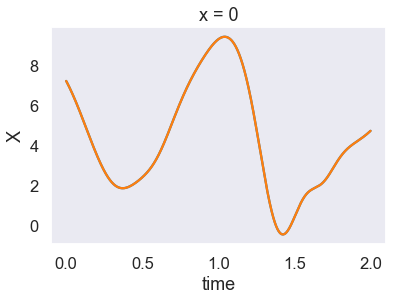

In [76]:
l96_nn.history.X.isel(x=0).plot();
l96_crm.history.X.isel(x=0).plot();

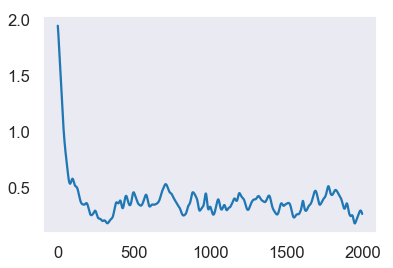

In [77]:
plt.plot(loss_history)

In [78]:
parameter_history = np.array(parameter_history).squeeze(); parameter_history.shape

(2000, 2)

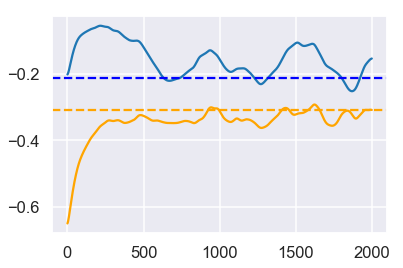

In [79]:
plt.plot(parameter_history[:, 0], c='orange')
plt.axhline(slope, c='orange', ls='--')
plt.plot(parameter_history[:, 1])
plt.axhline(intercept, c='blue', ls='--')
plt.grid()

### Several CRM time steps per GCM time step

In [112]:
net2= keras.models.load_model('/project/meteo/w2w/A6/S.Rasp/tmp/lr.h5')
nn_param = NNParam(net2)

In [113]:
l96_nn = L96TwoLevelNN(parameterization=nn_param, X_init=initX, Y_init=initY, save_dt=0.01, dt=0.01)
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.01)

In [114]:
loss_history = []
parameter_history = []
diff_history = []
for i in tqdm(range(2000)):
    diff = l96_crm.X - l96_nn.X
    diff_history.append(diff.mean())
    l96_crm.F = 10-diff/l96_crm.dt/10
    for i in range(10):
        l96_crm.step()
    
    l96_nn.step()  # Only X
    B = nn_param(l96_nn.X)
    target = (l96_crm.X - l96_nn.X) / l96_nn.dt
    l96_nn.X += B * l96_nn.dt
    
    loss = nn_param.net.train_on_batch(l96_nn.X, target)
    loss_history.append(loss)
    parameter_history.append(nn_param.net.get_weights())

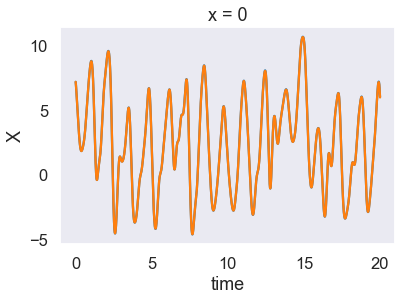

In [115]:
l96_nn.history.X.isel(x=0).plot();
l96_crm.history.X.isel(x=0).plot();

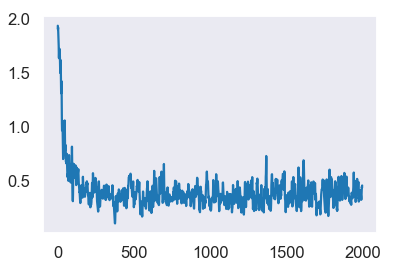

In [109]:
plt.plot(loss_history)

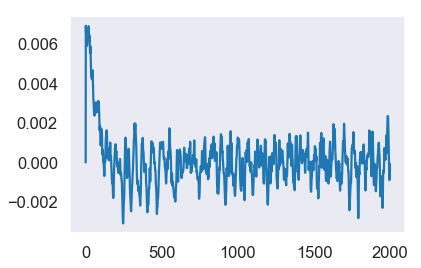

In [116]:
plt.plot(diff_history)

In [117]:
parameter_history = np.array(parameter_history).squeeze(); parameter_history.shape

(2000, 2)

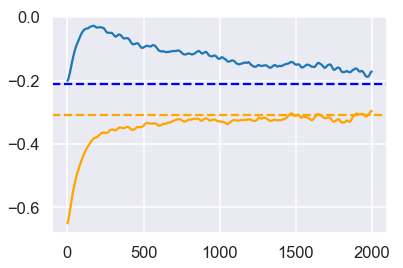

In [118]:
plt.plot(parameter_history[:, 0], c='orange')
plt.axhline(slope, c='orange', ls='--')
plt.plot(parameter_history[:, 1])
plt.axhline(intercept, c='blue', ls='--')
plt.grid()

## Same with neural net

In [119]:
nnet = keras.models.Sequential([
    Dense(32, input_shape=(1,), activation='elu'),
    Dense(32, activation='elu'),
    Dense(1)
])

In [120]:
nnet.compile('adam', 'mse')

In [121]:
nnet.fit(features_wrong, targets_wrong, epochs=30, verbose=1)

Epoch 1/30
7236/7236 [==============================] - 2s 290us/step - loss: 1.2610
Epoch 2/30
7236/7236 [==============================] - 1s 167us/step - loss: 1.0010
Epoch 3/30
7236/7236 [==============================] - 1s 156us/step - loss: 0.9641
Epoch 4/30
7236/7236 [==============================] - 1s 160us/step - loss: 0.9377
Epoch 5/30
7236/7236 [==============================] - 1s 161us/step - loss: 0.9174
Epoch 6/30
7236/7236 [==============================] - 1s 192us/step - loss: 0.9054
Epoch 7/30
7236/7236 [==============================] - 1s 189us/step - loss: 0.8947
Epoch 8/30
7236/7236 [==============================] - 1s 187us/step - loss: 0.8893
Epoch 9/30
7236/7236 [==============================] - 1s 192us/step - loss: 0.8800
Epoch 10/30
7236/7236 [==============================] - 1s 184us/step - loss: 0.8833
Epoch 11/30
7236/7236 [==============================] - 1s 191us/step - loss: 0.8800
Epoch 12/30
7236/7236 [==============================] - 1s 174

In [122]:
nnet.save('/project/meteo/w2w/A6/S.Rasp/tmp/nn.h5')

In [123]:
nnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [124]:
nnet2= keras.models.load_model('/project/meteo/w2w/A6/S.Rasp/tmp/nn.h5')
nn_param = NNParam(nnet2)

In [125]:
l96_nn = L96TwoLevelNN(parameterization=nn_param, X_init=initX, Y_init=initY, save_dt=0.01, dt=0.01)
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.01)

In [126]:
loss_history = []
parameter_history = []
diff_history = []
for i in tqdm(range(2000)):
    diff = l96_crm.X - l96_nn.X
    diff_history.append(diff.mean())
    l96_crm.F = 10-diff/l96_crm.dt/10
    for i in range(10):
        l96_crm.step()
    
    l96_nn.step()  # Only X
    B = nn_param(l96_nn.X)
    target = (l96_crm.X - l96_nn.X) / l96_nn.dt
    l96_nn.X += B * l96_nn.dt
    
    loss = nn_param.net.train_on_batch(l96_nn.X, target)
    loss_history.append(loss)
    parameter_history.append(nn_param.net.get_weights())

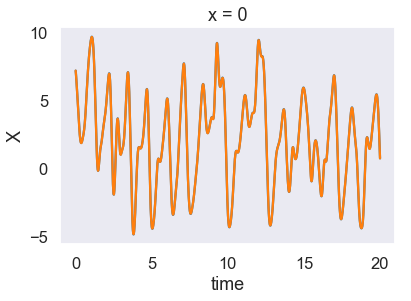

In [127]:
l96_nn.history.X.isel(x=0).plot();
l96_crm.history.X.isel(x=0).plot();

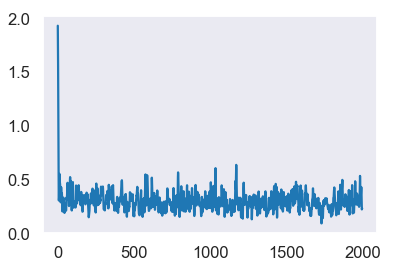

In [128]:
plt.plot(loss_history)

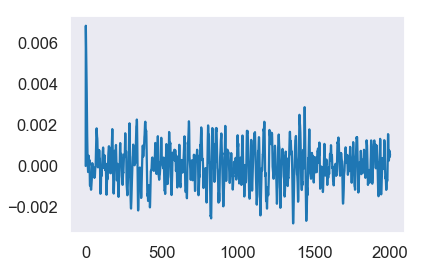

In [129]:
plt.plot(diff_history)

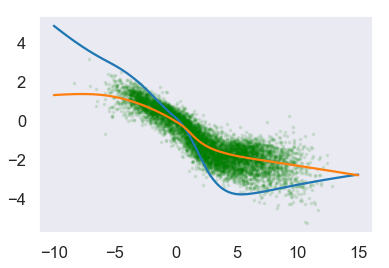

In [132]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1, c='g');
tmp = np.linspace(-10, 15, 100)
plt.plot(tmp, nnet.predict(tmp))
plt.plot(tmp, nnet2.predict(tmp))